## Decision Tree Implementation

Name: Umair X
Matricula: 5212660

## Import Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Generate Synthetic Data

Generating Diabetes patient data to predict whether a person has diabetes or not.

In [79]:
def data_generate(size):

    col_names = ['glucose', 'age', 'label']

    data_df = pd.DataFrame(columns=col_names)

    data_df['glucose'] = np.random.randint(40, 250, size=(size))
    data_df['age'] = np.random.randint(0.1, 100, size=(size))
    data_df['label'] = np.random.randint(-1,0, size=(size))
    
    for i in range(size):
        glucose = data_df.loc[i, 'glucose']
        age = data_df.loc[i, 'age']
        if ((glucose < 80) & (age < 50)) | ((glucose > 80) & (glucose < 160) & (age > 50)) | ((glucose > 160) & (glucose < 200) & (age < 40)) | ((glucose > 220) & (age > 70)):
            data_df.loc[i, 'label'] = 1        
#         if ((glucose > 140) & (glucose < 200)) | ((age > 40) & (age < 70) & (glucose > 220) ) | ((glucose < 80) & (age < 50)) | ((age > 3) & (age < 10) & (glucose > 220)):
#             data_df.loc[i, 'label'] = 1
            
# #         if (age > 15) & (glucose > 200):
# #             data_df.loc[i, 'label'] = 1
                
#         if (age <= 40) & (glucose < 80):
#             data_df.loc[i, 'label'] = 1
    
    X = data_df.iloc[:, :-1].values
    Y = data_df.iloc[:, -1].values.reshape(-1,1)
    
    return X, Y

# Graph of Dataset

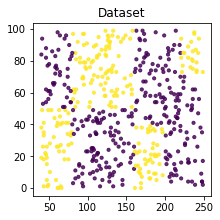

In [80]:
fig = plt.figure(figsize=(7,7)) 
ax0 = fig.add_subplot(2, 2, 1)
X, Y = data_generate(500)
ax0.set_title("Dataset")
ax0.scatter(X[:,0], X[:,1], s=10, c=Y, alpha=0.8)

# Add Some Noise in Data

In [81]:
def flipLabels(Y, perc):

    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return 0

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [82]:
YF = flipLabels(Y, 10)

# Create a Graph of dataset with some noises

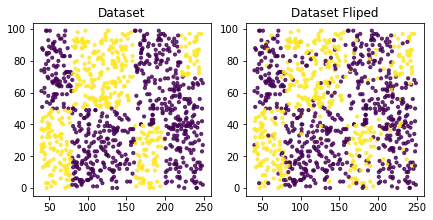

In [83]:
X, Y = data_generate(1000)
YF = flipLabels(Y, 10)
fig = plt.figure(figsize=(7,7)) 
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax0.set_title("Dataset")
ax1.set_title("Dataset Fliped")

ax0.scatter(X[:,0], X[:,1], s=10, c=Y, alpha=0.8)

ax1.scatter(X[:,0], X[:,1], s=10, c=YF, alpha=0.8)

## Node class

In [84]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

## Tree class

In [85]:
class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
#         print(num_features)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

## Train - Test Data split

In [86]:
# Generate Data
X_train, Y_train = data_generate(1600)
X_test, Y_test = data_generate(400)

## Fit the model

In [87]:
# Train Data
classifier = DecisionTree(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

# Test Data
Y_pred = classifier.predict(X_test) 
# Find Accuracy of Data
accuracy_score(Y_test, Y_pred)

X_0 <= 196 ? 0.05744950131011939
 left:X_0 <= 78 ? 0.004862189089536173
  left:X_1 <= 49 ? 0.9967916319816366
    left:1
    right:-1
  right:X_1 <= 51 ? 0.12419065882262115
    left:X_0 <= 160 ? 0.4983668972433584
        left:-1
        right:1
    right:X_0 <= 159 ? 0.7999167076936772
        left:1
        right:-1
 right:X_1 <= 71 ? 0.2725136711365168
  left:X_0 <= 199 ? 0.04883980646007025
    left:X_1 <= 35 ? 0.74959525725948
        left:1
        right:-1
    right:-1
  right:X_0 <= 220 ? 0.9997779672118906
    left:-1
    right:1


0.97

The result accuracy is 0.915 with data without noise. And the max depth I set is 3. The result is good but there is no noise on it. Let's check with noisy data.

# Train with noisy data

In [94]:
# add some noise to data
Y_train_f = flipLabels(Y_train, 10)
Y_train_f = np.vstack(Y_train_f)

# Train Data
classifier = DecisionTree(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train_f)
classifier.print_tree()

# Test Data
Y_pred = classifier.predict(X_test) 
# Find Accuracy of Data
accuracy_score(Y_test, Y_pred)

X_0 <= 196 ? 0.03927043703221256
 left:X_1 <= 39 ? 0.005183436859792723
  left:X_0 <= 79 ? 0.157025070388496
    left:X_1 <= 17 ? 0.027151646010543207
        left:1
        right:1
    right:X_0 <= 160 ? 0.42541667831627494
        left:-1
        right:1
  right:X_0 <= 159 ? 0.13400544651950397
    left:X_0 <= 80 ? 0.15634467480145264
        left:-1
        right:1
    right:X_0 <= 166 ? 0.025986355608727918
        left:-1
        right:-1
 right:X_1 <= 72 ? 0.12489980123482258
  left:X_0 <= 217 ? 0.012794746577928562
    left:X_1 <= 54 ? 0.026544576049204627
        left:-1
        right:-1
    right:X_1 <= 57 ? 0.014025999146161094
        left:-1
        right:-1
  right:X_0 <= 220 ? 0.6634963412457262
    left:X_1 <= 81 ? 0.08034783314955049
        left:-1
        right:-1
    right:X_0 <= 248 ? 0.087227935321678
        left:1
        right:-1


0.935

After add some noise the result accuracy decline which is expected. Now will try same data with some increase of max depth.

# Test with change max depth

try with max_depth 5 to see the result

In [96]:
# Train Data
classifier = DecisionTree(min_samples_split=3, max_depth=5)
classifier.fit(X_train,Y_train_f)
# classifier.print_tree()

# Test Data
Y_pred = classifier.predict(X_test) 
# Find Accuracy of Data
accuracy_score(Y_test, Y_pred)

0.9925

See the difference, when I increase max depth the result accuracy changed completly and I got very good result after change max depth.

# Try with SK learn Algorithm

compare the result with sk learn algorithm. Let's check and compare the accuracy result with my algorithm.

In [90]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics 

In [97]:
Y_train_f = flipLabels(Y_train, 10)
Y_train_f = np.vstack(Y_train_f)

In [101]:
clf = DecisionTreeClassifier(max_depth=5)
# Train Decision Tree Classifer
clf = clf.fit(X_train,Y_train_f)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [100]:
accuracy_score(Y_test, y_pred)

0.985

The acuracy result is 0.99 which is very good. Our own algorithm accuracy result is 0.99. 